---
title: "DS202W - Group Project"
author: "Civic Tensor (Group 2)"
output: html
self-contained: true
jupyter: python3
engine: jupyter
editor:
  render-on-save: true
  preview: true
---

In [29]:
# Import relevant libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, TimeSeriesSplit, GridSearchCV, HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, root_mean_squared_error, roc_auc_score, roc_curve, f1_score, fbeta_score, \
                            precision_score, recall_score, precision_recall_curve, average_precision_score, make_scorer, r2_score, mean_squared_error, \
                            mean_absolute_error, mean_squared_log_error, median_absolute_error, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.exceptions import FitFailedWarning
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline, Pipeline
import statsmodels.api as sm
from lets_plot import *
LetsPlot.setup_html()
from lets_plot.plot import gggrid
from pytablewriter import MarkdownTableWriter
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import catboost
import missingno as msno
import seaborn as sns
from sklearn.svm import SVR
import sweetviz as sv
from collections import Counter
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
from plotnine.themes.themeable import themeable
from plotnine import ggplot, aes, geom_bar, theme_minimal, options
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Open the data file
df = pd.read_csv('ds202w-group-projects-civil-war.csv')

In [3]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7140 entries, 0 to 7139
Data columns (total 94 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7140 non-null   int64  
 1   cowcode     7140 non-null   int64  
 2   year        7140 non-null   int64  
 3   warstds     7140 non-null   int64  
 4   ager        7140 non-null   float64
 5   agexp       7140 non-null   float64
 6   anoc        7140 non-null   int64  
 7   army85      7140 non-null   float64
 8   autch98     7140 non-null   int64  
 9   auto4       7140 non-null   float64
 10  autonomy    7140 non-null   float64
 11  avgnabo     7140 non-null   float64
 12  centpol3    7140 non-null   int64  
 13  coldwar     7140 non-null   int64  
 14  decade1     7140 non-null   int64  
 15  decade2     7140 non-null   int64  
 16  decade3     7140 non-null   int64  
 17  decade4     7140 non-null   int64  
 18  dem         7140 non-null   int64  
 19  dem4        7140 non-null  

In [4]:
df.head()

,Unnamed: 0,cowcode,year,warstds,ager,agexp,anoc,army85,autch98,auto4,...,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
0,1,700,1945,0,34.461765,8.510845,0,129472.9042,0,3.925812,...,43.770298,0.253,0.058441,0.46176,0.158275,0.052989,0.443259,72.881375,0,3.995912
1,2,700,1946,0,34.346348,8.478997,0,129413.0225,0,10.000000,...,43.588363,0.253,0.000000,0.00000,0.158321,0.052663,1.000000,72.900089,0,1.000000
2,3,700,1947,0,77.000000,8.481015,0,130431.0145,0,10.000000,...,43.538181,0.253,0.000000,0.00000,0.158425,0.052891,2.000000,72.962880,0,1.000000
3,4,700,1948,0,78.000000,8.451628,0,126781.6866,0,10.000000,...,43.490005,0.253,0.000000,0.00000,0.159006,0.052902,2.000000,73.102449,0,1.000000
4,5,700,1949,0,79.000000,8.500172,0,130979.2470,0,10.000000,...,43.602238,0.253,0.000000,0.00000,0.158074,0.052706,2.000000,72.850389,0,1.000000


In [5]:
# Count the number of countries 
df['cowcode'].nunique()

178

Defining the variables used in the initial paper

In [6]:
# Dropping unnecessary columns
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Define the list of columns based on what the author chose to keep
cols_of_interest = [
    'cowcode',
    'year',
    'warstds',
    'pol4', 'polcomp',
    'ln_gdpen',
    'lpopns',
    'infant',
    'milper',
    'elfo', 'elfo2',
    'oil',
    'lmtnest',
    'dem', 'dem4', 'parcomp',
    'auto4', 'autch98', 'autonomy'
]

top_features = [
    'ehet', 'seceduc', 'ager', 'ef', 'popdense', 'fuelexp', 'dlang', 'nmgdp',
    'agexp', 'lpopns', 'gdpgrowth', 'sxpnew', 'army85', 'elfo', 'manuexp',
    'milper', 'trade', 'illiteracy', 'expgdp', 'sxpsq'
]

# Combine both lists and remove duplicates
all_columns = list(set(cols_of_interest + top_features))

# Filter DataFrame to keep only these columns (include only those that exist)
filtered_df = df[[col for col in all_columns if col in df.columns]]

# Display the first few rows of the filtered DataFrame
filtered_df.head()

,gdpgrowth,dem4,expgdp,ager,ef,warstds,autch98,lmtnest,illiteracy,sxpsq,...,auto4,milper,sxpnew,elfo,dlang,army85,dem,pol4,cowcode,infant
0,0.022562,3.995929,33.592410,34.461765,0.750797,0,0,4.198705,34.020639,0.052989,...,3.925812,121.087366,0.158275,66.0,70.0,129472.9042,0,0.070117,700,68.655361
1,0.022447,0.000000,33.561559,34.346348,0.750797,0,0,4.198705,34.129908,0.052663,...,10.000000,121.885359,0.158321,66.0,70.0,129413.0225,0,-10.000000,700,68.918002
2,0.022372,0.000000,33.577128,77.000000,0.750797,0,0,4.198705,34.183272,0.052891,...,10.000000,122.780608,0.158425,66.0,70.0,130431.0145,0,-10.000000,700,69.017545
3,0.022239,0.000000,33.625990,78.000000,0.750797,0,0,4.198705,34.234445,0.052902,...,10.000000,118.256427,0.159006,66.0,70.0,126781.6866,0,-10.000000,700,69.126788
4,0.022462,0.000000,33.538608,79.000000,0.750797,0,0,4.198705,34.164099,0.052706,...,10.000000,122.245074,0.158074,66.0,70.0,130979.2470,0,-10.000000,700,68.960291


### Exploring the Missing Data (Will streamline in final version) 

In [7]:
import pandas as pd

# 1. Define the expected year range (inclusive of 2000)
expected_years = set(range(1945, 2001))

# 2. Find missing years per cowcode
missing_years_by_cowcode = {}

for cowcode, group in df.groupby('cowcode'):
    years_present = set(group['year'].unique())
    missing_years = expected_years - years_present
    if missing_years:
        missing_years_by_cowcode[cowcode] = sorted(missing_years)

# 3. Check if any of those cowcodes had warstds == 1
civil_war_flags = {
    cowcode: int((df[(df['cowcode'] == cowcode) & (df['warstds'] == 1)].shape[0]) > 0)
    for cowcode in missing_years_by_cowcode.keys()
}

# 4. Create summary table
missing_df = pd.DataFrame([
    {
        'cowcode': cowcode,
        'missing_years': missing_years_by_cowcode[cowcode],
        'had_civil_war': civil_war_flags[cowcode]
    }
    for cowcode in missing_years_by_cowcode
])

# 5. Print answers
print("1) Year range used: 1945 to 2000 inclusive")
print(f"2) Number of cowcodes with missing years: {len(missing_years_by_cowcode)}")
print(f"3) Number of these cowcodes that had a civil war: {missing_df['had_civil_war'].sum()}")

print("\nTable of cowcodes with missing years and civil war status:")
missing_df.head()

1) Year range used: 1945 to 2000 inclusive
2) Number of cowcodes with missing years: 119
3) Number of these cowcodes that had a civil war: 49

Table of cowcodes with missing years and civil war status:


,cowcode,missing_years,had_civil_war
0,31,"[1945, 1946, 1947, 1948, 1949, 1950, 1951, 195...",0
1,51,"[1945, 1946, 1947, 1948, 1949, 1950, 1951, 195...",0
2,52,"[1945, 1946, 1947, 1948, 1949, 1950, 1951, 195...",0
3,53,"[1945, 1946, 1947, 1948, 1949, 1950, 1951, 195...",0
4,55,"[1945, 1946, 1947, 1948, 1949, 1950, 1951, 195...",0


Checking to see which countries have more than 5 consecutive missing years - this might be too many to interpolate

In [8]:
# Define expected year range
expected_years = set(range(1945, 2001))

def find_consecutive_sequences(years, min_length=5):
    """Finds sequences of consecutive years in a list, returns True if any are longer than min_length."""
    if not years:
        return False
    sorted_years = sorted(years)
    count = 1
    for i in range(1, len(sorted_years)):
        if sorted_years[i] == sorted_years[i-1] + 1:
            count += 1
            if count > min_length:
                return True
        else:
            count = 1
    return False

# Store info
missing_years_by_cowcode = {}
consecutive_gap_flags = {}

for cowcode, group in df.groupby('cowcode'):
    years_present = set(group['year'].unique())
    missing_years = sorted(expected_years - years_present)
    if missing_years:
        missing_years_by_cowcode[cowcode] = missing_years
        consecutive_gap_flags[cowcode] = find_consecutive_sequences(missing_years, min_length=20)

# Civil war flags
civil_war_flags = {
    cowcode: int((df[(df['cowcode'] == cowcode) & (df['warstds'] == 1)].shape[0]) > 0)
    for cowcode in missing_years_by_cowcode
}

# Summary table
missing_df = pd.DataFrame([
    {
        'cowcode': cowcode,
        'missing_years': missing_years_by_cowcode[cowcode],
        'had_civil_war': civil_war_flags[cowcode],
        'has_5+_consecutive_missing': consecutive_gap_flags[cowcode]
    }
    for cowcode in missing_years_by_cowcode
])

# Output
print("1) Year range used: 1945 to 2000 inclusive")
print(f"2) Number of cowcodes with missing years: {len(missing_years_by_cowcode)}")
print(f"3) Number of these cowcodes that had a civil war: {missing_df['had_civil_war'].sum()}")
print(f"4) Number of countries with 5+ consecutive missing years: {missing_df['has_5+_consecutive_missing'].sum()}")

print("\nTable of cowcodes with missing years, civil war status, and long gaps:")
print(missing_df.head())

1) Year range used: 1945 to 2000 inclusive
2) Number of cowcodes with missing years: 119
3) Number of these cowcodes that had a civil war: 49
4) Number of countries with 5+ consecutive missing years: 58

Table of cowcodes with missing years, civil war status, and long gaps:
   cowcode                                      missing_years  had_civil_war  \
0       31  [1945, 1946, 1947, 1948, 1949, 1950, 1951, 195...              0   
1       51  [1945, 1946, 1947, 1948, 1949, 1950, 1951, 195...              0   
2       52  [1945, 1946, 1947, 1948, 1949, 1950, 1951, 195...              0   
3       53  [1945, 1946, 1947, 1948, 1949, 1950, 1951, 195...              0   
4       55  [1945, 1946, 1947, 1948, 1949, 1950, 1951, 195...              0   

   has_5+_consecutive_missing  
0                        True  
1                       False  
2                       False  
3                        True  
4                        True  


In [9]:
# Print cowcodes with more than 5 consecutive missing years and their missing years
print("\nCountries with more than 5 consecutive missing years and the years missing:")

for _, row in missing_df[missing_df['has_5+_consecutive_missing']].iterrows():
    print(f"COWCODE {row['cowcode']}: Missing years: {row['missing_years']}")



Countries with more than 5 consecutive missing years and the years missing:
COWCODE 31: Missing years: [1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972]
COWCODE 53: Missing years: [1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965]
COWCODE 55: Missing years: [1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973]
COWCODE 80: Missing years: [1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980]
COWCODE 110: Missing years: [1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 19

In [10]:
# Find all years where any country had a civil war (warstds == 1)
civil_war_years = sorted(df[df['warstds'] == 1]['year'].unique())

print("Years in which at least one country had a civil war:")
print(civil_war_years)


Years in which at least one country had a civil war:
[1946, 1947, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956, 1958, 1959, 1960, 1961, 1962, 1963, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1988, 1989, 1990, 1991, 1992, 1994, 1995, 1996, 1997, 1998, 1999]


Correlation Analysis

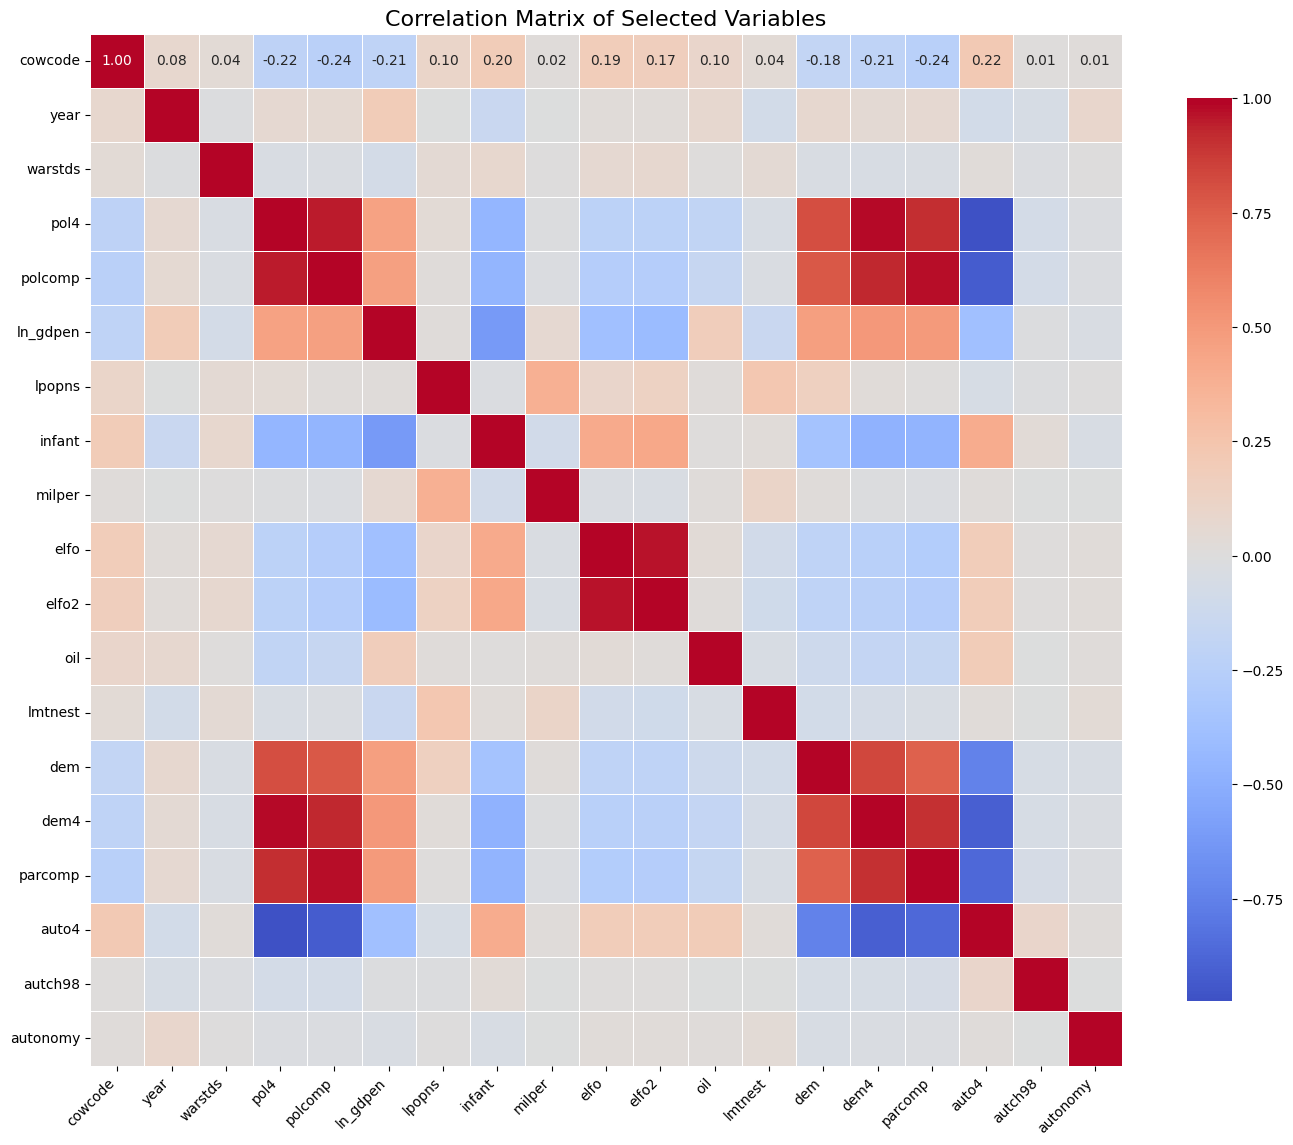

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

X_cols =[
    'pol4', 'polcomp', 'ln_gdpen', 'lpopns', 'infant', 'milper',
    'elfo', 'elfo2', 'oil', 'lmtnest', 'dem', 'dem4', 'parcomp',
    'auto4', 'autch98', 'autonomy'
]

# Filter the DataFrame (in case some columns are missing)
filtered_df = df[[col for col in cols_of_interest if col in df.columns]]

# Compute correlation matrix
corr_matrix = filtered_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Selected Variables", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### **K-Nearest Neighbours (KNN) Classification Model**

The K-Nearest Neighbours (KNN) algorithm is a supervised classification method that predicts the label of a new data point by examining the ‘K’ most similar observations in the training set. It assigns the class that appears most frequently among these neighbours to the input point.

KNN is known as a non-parametric and instance-based approach. Rather than learning an internal model during training, it stores the entire dataset and performs calculations only at the time of prediction. This is why it’s often described as a lazy learning algorithm.

To determine the nearest neighbours, the model typically uses a distance measure such as Euclidean distance. The number of neighbours considered, denoted by ‘K’, significantly influences the model’s behaviour. A low value of K can result in noisy, overfitted predictions, whereas a high K may cause the model to overlook more nuanced patterns.

Again, to preserve the chronology of the data and to be consistent, we use the same time-based split for training and testing the KNN model.

Doing Cross Validation according to the Cowcode, and the split is done by Cowcode too

In [ ]:

warnings.filterwarnings("ignore")
df_knn = filtered_df.copy()

# Train / test split:   
train_mask = df_knn['year'] < 1990        
test_mask  = df_knn['year'] >= 1990       

X_cols = [c for c in df_knn.columns if c != 'warstds']
y      = df_knn['warstds']

X_train_full = df_knn.loc[train_mask, X_cols]
y_train_full = y.loc[train_mask]

X_test_full  = df_knn.loc[test_mask,  X_cols]
y_test_full  = y.loc[test_mask]

# Define missing variables
X_train_sorted = X_train_full.sort_values('year').reset_index(drop=True)
y_train_sorted = y_train_full.iloc[X_train_sorted.index]
feature_cols = [c for c in X_train_sorted.columns if c not in ['cowcode', 'year']]

# Find best_k using macro-F1 across folds
best_k = None
best_f1 = -1

for k in range(1, 21):
    fold_f1s = []
    tscv_k = TimeSeriesSplit(n_splits=3)

    for tr_idx, val_idx in tscv_k.split(X_train_sorted):
        X_tr  = X_train_sorted.iloc[tr_idx][feature_cols]
        X_val = X_train_sorted.iloc[val_idx][feature_cols]
        y_tr  = y_train_sorted.iloc[tr_idx]
        y_val = y_train_sorted.iloc[val_idx]

        scaler_k = StandardScaler()
        X_tr_scaled  = scaler_k.fit_transform(X_tr)
        X_val_scaled = scaler_k.transform(X_val)

        knn_k = KNeighborsClassifier(n_neighbors=k)
        knn_k.fit(X_tr_scaled, y_tr)
        y_val_pred = knn_k.predict(X_val_scaled)

        f1 = f1_score(y_val, y_val_pred, average='macro')
        fold_f1s.append(f1)

    avg_f1 = np.mean(fold_f1s)
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_k = k

print(f"Best k selected via CV: {best_k} (avg macro F1 = {best_f1:.4f})")

# CV performance (concatenated validation folds)
y_cv_true, y_cv_pred = [], []
tscv = TimeSeriesSplit(n_splits=3)

for tr_idx, val_idx in tscv.split(X_train_sorted):
    X_tr  = X_train_sorted.iloc[tr_idx][feature_cols]
    X_val = X_train_sorted.iloc[val_idx][feature_cols]
    y_tr  = y_train_sorted.iloc[tr_idx]
    y_val = y_train_sorted.iloc[val_idx]

    scaler_cv = StandardScaler()
    X_tr_scaled  = scaler_cv.fit_transform(X_tr)
    X_val_scaled = scaler_cv.transform(X_val)

    knn_cv = KNeighborsClassifier(n_neighbors=best_k)
    knn_cv.fit(X_tr_scaled, y_tr)
    y_cv_pred.extend(knn_cv.predict(X_val_scaled))
    y_cv_true.extend(y_val)

print("\n=== CV (concatenated validation folds) ===")
print(classification_report(y_cv_true, y_cv_pred, labels=[0, 1], zero_division=0))

# Re-fit on all training data  
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train_sorted[feature_cols])
X_test_scaled  = scaler_final.transform(X_test_full[feature_cols])

final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train_sorted)

y_train_pred = final_knn.predict(X_train_scaled)
print("\n=== Overall TRAIN set ( < 1990 ) ===")
print(classification_report(y_train_sorted, y_train_pred, labels=[0, 1], zero_division=0))

# Test set performance
y_test_pred = final_knn.predict(X_test_scaled)
print("\n=== Overall TEST set ( ≥ 1990 ) ===")
print(classification_report(y_test_full, y_test_pred, labels=[0, 1], zero_division=0))


Best k selected via CV: 1 (avg macro F1 = 0.5022)

=== CV (concatenated validation folds) ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3906
           1       0.02      0.02      0.02        66

    accuracy                           0.97      3972
   macro avg       0.50      0.50      0.50      3972
weighted avg       0.97      0.97      0.97      3972


=== Overall TRAIN set ( < 1990 ) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5211
           1       1.00      1.00      1.00        88

    accuracy                           1.00      5299
   macro avg       1.00      1.00      1.00      5299
weighted avg       1.00      1.00      1.00      5299


=== Overall TEST set ( ≥ 1990 ) ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1813
           1       0.00      0.00      0.00        28

    accuracy 

**Taking Growth Rates** 

As we are now combining the countries and sorting them by year, the growth rates are more reliable than the absolute values. We will take the growth rates of the variables and use them for the KNN model.

The growth rates calculations only start with the first non-zero data point due to the large number of missing values in the beginning of the dataset. For the first entry, we will assume it to be the same growth rate as year (X+1). 

For missing years in between, we will first calculate the growth rate relative to the next available year, and then we will take the compounded annual growth rate (CAGR) for the years in between. This will give us a more accurate representation of the growth rates, as we are not just taking the difference between two years, but rather the compounded growth over the years.

In [ ]:

# Base frame and columns that need growth rates
df_growth = filtered_df.copy()
df_growth = df_growth.sort_values(['cowcode', 'year']).reset_index(drop=True)

g_cols = [c for c in df_growth.columns if c not in ['cowcode', 'year', 'warstds']]


# Growth calculator obeying your rules
def _growth_series(values: pd.Series) -> pd.Series:
    """
    Per-country numeric Series indexed by *year* (continuous).
    Returns decimal growth rates:
      • first row copies second row’s growth
      • gaps get CAGR if both end-points > 0
      • otherwise gaps (and pure zeros) get 0
    """
    n = len(values)
    growth = np.zeros(n, dtype=float)          # default 0 growth everywhere

    # indices where the series has a strictly positive value
    good_idx = np.where(values.to_numpy() > 0)[0]

    if len(good_idx) == 0:
        # all zeros or NaNs  → keep growth = 0
        return pd.Series(growth, index=values.index)

    # iterate over consecutive known points
    for i in range(1, len(good_idx)):
        idx_prev, idx_curr = good_idx[i-1], good_idx[i]
        val_prev, val_curr = values.iloc[idx_prev], values.iloc[idx_curr]

        gap_len = idx_curr - idx_prev
        # CAGR only if both ends are > 0
        r = (val_curr / val_prev) ** (1 / gap_len) - 1

        growth[idx_prev + 1 : idx_curr + 1] = r     # fill every step incl. curr

    # first row copies the second row’s growth (if it exists)
    if n > 1:
        growth[0] = growth[1]

    return pd.Series(growth, index=values.index)

# Apply to every (cowcode, column) pair
def _apply_growth(df_grp: pd.DataFrame) -> pd.DataFrame:
    yr_range = range(df_grp['year'].min(), df_grp['year'].max() + 1)
    df_grp = df_grp.set_index('year')
    df_grp['cowcode'] = df_grp['cowcode'].ffill()        # constant per group

    for col in g_cols:
        df_grp[col] = _growth_series(df_grp[col])

    return df_grp.reset_index()

df_growth = (
    df_growth
      .groupby('cowcode', group_keys=False)
      .apply(_apply_growth)
      .reset_index(drop=True)
)

# 4.  Final clean-up   
df_growth[g_cols] = df_growth[g_cols].replace([np.inf, -np.inf], 0).fillna(0)


In [ ]:
warnings.filterwarnings("ignore")

# Train / test split for df_growth (% changes)
train_mask_growth = df_growth['year'] < 1990        
test_mask_growth  = df_growth['year'] >= 1990       

X_cols_growth = [c for c in df_growth.columns if c != 'warstds']
y_growth      = df_growth['warstds']

X_train_growth = df_growth.loc[train_mask_growth, X_cols_growth]
y_train_growth = y_growth.loc[train_mask_growth]

X_test_growth  = df_growth.loc[test_mask_growth,  X_cols_growth]
y_test_growth  = y_growth.loc[test_mask_growth]

# Chronologically sort training set
train_joined = X_train_growth.copy()
train_joined['warstds'] = y_train_growth.values
train_joined = train_joined.sort_values('year').reset_index(drop=True)

X_train_sorted_growth = train_joined.drop(columns='warstds')
y_train_sorted_growth = train_joined['warstds']

feature_cols_growth = [c for c in X_train_sorted_growth.columns if c not in ['cowcode', 'year']]

# CV performance (concatenated val folds)
y_cv_true_growth, y_cv_pred_growth = [], []
tscv_growth = TimeSeriesSplit(n_splits=3)

for tr_idx, val_idx in tscv_growth.split(X_train_sorted_growth):
    X_tr  = X_train_sorted_growth.iloc[tr_idx][feature_cols_growth]
    X_val = X_train_sorted_growth.iloc[val_idx][feature_cols_growth]
    y_tr  = y_train_sorted_growth.iloc[tr_idx]
    y_val = y_train_sorted_growth.iloc[val_idx]

    scaler_cv_growth = StandardScaler()
    X_tr_scaled  = scaler_cv_growth.fit_transform(X_tr)
    X_val_scaled = scaler_cv_growth.transform(X_val)

    knn_cv_growth = KNeighborsClassifier(n_neighbors=best_k)
    knn_cv_growth.fit(X_tr_scaled, y_tr)
    y_cv_pred_growth.extend(knn_cv_growth.predict(X_val_scaled))
    y_cv_true_growth.extend(y_val)

print("\n=== CV (concatenated validation folds on growth data) ===")
print(classification_report(y_cv_true_growth, y_cv_pred_growth))

# Re-fit on full training growth data
scaler_final_growth = StandardScaler()
X_train_scaled_growth = scaler_final_growth.fit_transform(X_train_sorted_growth[feature_cols_growth])
X_test_scaled_growth  = scaler_final_growth.transform(X_test_growth[feature_cols_growth])

final_knn_growth = KNeighborsClassifier(n_neighbors=best_k)
final_knn_growth.fit(X_train_scaled_growth, y_train_sorted_growth)

y_train_pred_growth = final_knn_growth.predict(X_train_scaled_growth)
print("\n=== Overall TRAIN set (growth data, < 1990) ===")
print(classification_report(y_train_sorted_growth, y_train_pred_growth))

# Test set performance on growth data
y_test_pred_growth = final_knn_growth.predict(X_test_scaled_growth)
print("\n=== Overall TEST set (growth data, ≥ 1990) ===")
print(classification_report(y_test_growth, y_test_pred_growth))



=== CV (concatenated validation folds on growth data) ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3907
           1       0.12      0.15      0.13        65

    accuracy                           0.97      3972
   macro avg       0.55      0.57      0.56      3972
weighted avg       0.97      0.97      0.97      3972


=== Overall TRAIN set (growth data, < 1990) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5211
           1       0.92      0.95      0.94        88

    accuracy                           1.00      5299
   macro avg       0.96      0.98      0.97      5299
weighted avg       1.00      1.00      1.00      5299


=== Overall TEST set (growth data, ≥ 1990) ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1813
           1       0.02      0.04      0.02        28

    accuracy              

In [30]:

warnings.filterwarnings("ignore")

# Train / test split:   
train_mask = df_knn['year'] < 1990        
test_mask  = df_knn['year'] >= 1990       

X_cols = [c for c in df_knn.columns if c != 'warstds']
y      = df_knn['warstds']

X_train_full = df_knn.loc[train_mask, X_cols]
y_train_full = y.loc[train_mask]

X_test_full  = df_knn.loc[test_mask,  X_cols]
y_test_full  = y.loc[test_mask]

# Chronologically sort training data
X_train_sorted = X_train_full.sort_values('year').reset_index(drop=True)
y_train_sorted = y_train_full.iloc[X_train_sorted.index]
feature_cols = [c for c in X_train_sorted.columns if c not in ['cowcode', 'year']]

# Apply downsampling on the training set
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.2)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_sorted[feature_cols], y_train_sorted)

# Find best_k using macro-F1 across folds (on downsampled data)
best_k = None
best_f1 = -1

for k in range(1, 21):
    fold_f1s = []
    tscv_k = TimeSeriesSplit(n_splits=3)

    for tr_idx, val_idx in tscv_k.split(X_train_resampled):
        X_tr = X_train_resampled.iloc[tr_idx]
        X_val = X_train_resampled.iloc[val_idx]
        y_tr = y_train_resampled.iloc[tr_idx]
        y_val = y_train_resampled.iloc[val_idx]

        scaler_k = StandardScaler()
        X_tr_scaled = scaler_k.fit_transform(X_tr)
        X_val_scaled = scaler_k.transform(X_val)

        knn_k = KNeighborsClassifier(n_neighbors=k)
        knn_k.fit(X_tr_scaled, y_tr)
        y_val_pred = knn_k.predict(X_val_scaled)

        f1 = f1_score(y_val, y_val_pred, average='macro')
        fold_f1s.append(f1)

    avg_f1 = np.mean(fold_f1s)
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_k = k

print(f"Best k selected via CV (downsampled): {best_k} (avg macro F1 = {best_f1:.4f})")

# CV performance (concatenated validation folds)
y_cv_true, y_cv_pred = [], []
tscv = TimeSeriesSplit(n_splits=3)

for tr_idx, val_idx in tscv.split(X_train_resampled):
    X_tr = X_train_resampled.iloc[tr_idx]
    X_val = X_train_resampled.iloc[val_idx]
    y_tr = y_train_resampled.iloc[tr_idx]
    y_val = y_train_resampled.iloc[val_idx]

    scaler_cv = StandardScaler()
    X_tr_scaled = scaler_cv.fit_transform(X_tr)
    X_val_scaled = scaler_cv.transform(X_val)

    knn_cv = KNeighborsClassifier(n_neighbors=best_k)
    knn_cv.fit(X_tr_scaled, y_tr)
    y_cv_pred.extend(knn_cv.predict(X_val_scaled))
    y_cv_true.extend(y_val)

print("\n=== CV (concatenated validation folds on downsampled data) ===")
print(classification_report(y_cv_true, y_cv_pred, labels=[0, 1], zero_division=0))

# Re-fit on full downsampled training data
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train_resampled)
X_test_scaled = scaler_final.transform(X_test_full[feature_cols])

final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train_resampled)

y_train_pred = final_knn.predict(X_train_scaled)
print("\n=== Overall TRAIN set (downsampled, < 1990) ===")
print(classification_report(y_train_resampled, y_train_pred, labels=[0, 1], zero_division=0))

# Test set performance (unchanged test set)
y_test_pred = final_knn.predict(X_test_scaled)
print("\n=== Overall TEST set ( ≥ 1990 ) ===")
print(classification_report(y_test_full, y_test_pred, labels=[0, 1], zero_division=0))


Best k selected via CV (downsampled): 1 (avg macro F1 = 0.7500)

=== CV (concatenated validation folds on downsampled data) ===
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       308
           1       0.00      0.00      0.00        88

    accuracy                           0.78       396
   macro avg       0.39      0.50      0.44       396
weighted avg       0.60      0.78      0.68       396


=== Overall TRAIN set (downsampled, < 1990) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       1.00      1.00      1.00        88

    accuracy                           1.00       528
   macro avg       1.00      1.00      1.00       528
weighted avg       1.00      1.00      1.00       528


=== Overall TEST set ( ≥ 1990 ) ===
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      1813
           1       0.03

In [33]:
import plotly.figure_factory as ff
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test_full, y_test_pred, labels=[0, 1])
labels = ["Class 0", "Class 1"]

# Plot using Plotly
z = cm
x = labels
y = labels

fig = ff.create_annotated_heatmap(
    z=z,
    x=x,
    y=y,
    colorscale='Blues',
    showscale=True,
    annotation_text=[[str(cell) for cell in row] for row in z],
)

fig.update_layout(
    title="Confusion Matrix (Test Set)",
    xaxis_title="Predicted Label",
    yaxis_title="True Label",
)
fig.update_yaxes(autorange='reversed')
fig.show()